# K-Nearest Neighbor Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sk_shuffle
from scipy.io import arff

In [127]:
x = np.array([[1, 0, 0, 2], 
              [0, 5, 6, 4], 
              [7, 8, 9, 1]])
y = np.array([2, 0, 1, 4])
result = np.linalg.norm(x - y, ord=2, axis=1)

x = x[:, [0, 2]]
y = y[[0, 2]]
print(y)


[2 1]


In [2]:
from sklearn.preprocessing import LabelEncoder

class arffLoader():
  def arf_to_np(self, arf_path, data_type=float):
      data_raw, meta = arff.loadarff(arf_path)
      names = np.array(data_raw.dtype.names)
      data_bytes = np.array(data_raw.tolist())
      return data_bytes.astype(data_type), names

  def split_x_y(self, array):
      num_col = array.shape[1]
      X = array[:, 0:num_col - 1]
      y = array[:,-1]  # https://stackoverflow.com/questions/32764200/numpy-slicing-2d-row-or-column-vector-from-array
      return X, y

  def arf_to_x_y(self, arf_path, data_type=float, do_encode=False):
        """
        :param arf_path:
        :param data_type:
        :param num_targets:
        :param do_encode: bool, indicates whether or not the data should be encoded as continuous (go from nominal/categorical to continuous)
        :return:
        """
        data, names = self.arf_to_np(arf_path, data_type)
        if do_encode:
            le = LabelEncoder()
            data = np.apply_along_axis(le.fit_transform, 0, data)
        X, y = self.split_x_y(data)
        return X, y, names

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [113]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', regression=False, n_neighbors=5, p=2, normalize=False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.n_neighbors = n_neighbors
        self.p = p
        self.X = None
        self.y = None
        self.labels = None
        self.regression = regression
        self.normalize = normalize

    def fit(self, X, y):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X_original = X
        self.y_original = y
        self.X = X
        self.y = y
        self.labels = np.unique(y)
        return self
    
    def predict(self, data):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        if self.normalize:
            min_train = self.X.min(axis=0)
            max_train = self.X.max(axis=0)
            min_test = data.min(axis=0)
            max_test = data.max(axis=0)
            min = np.minimum(min_train, min_test)
            max = np.maximum(max_train, max_test)
            data = (data - min) / (max - min)
            self.X = (self.X_original - min) / (max - min)
            

        predictions = np.empty(len(data), dtype=self.y.dtype)
        for i, instance in enumerate(data):
            predictions[i] = self.predict_instance(instance)
            # TODO: remove these two lines
            # self.X = np.vstack((self.X, instance))  # add the instance to the training data
            # self.y = np.append(self.y, predictions[i])  # add the prediction to the training data
        return predictions

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)
        if self.regression:
            diffs = predictions - y
            mse = np.mean(np.square(predictions - y))
            return np.mean(np.square(predictions - y))
        else:
            return np.sum(predictions == y) / len(y)
    
    def kronecker(self, a, b):
        return 1 if a==b else 0

    def get_best(self, neighbor_y, neighbor_distances):
        """
        :param class_values: list of possible class values
        :param neighbor_y: list of class values of the k nearest neighbors
        :param neighbor_distances: list of distances to the k nearest neighbors
        :param weight_type: type of weighting to use
        :return: the class value with the highest sum of votes
        """
        best_class = None
        best_sum = -1
        # loop through class values of the k nearest neighbors
        for target in np.unique(neighbor_y):
            if self.weight_type == 'inverse_distance':
                sum = np.sum((1 / np.square(neighbor_distances)) * (neighbor_y == target))
            else:
                sum = np.sum(neighbor_y == target)
                
            if sum > best_sum:
                best_sum = sum
                best_class = target

        # print(f'sum of votes for predicted class label: {best_sum}')
        return best_class

    def regressor(self, neighbors_y, neighbor_distances):
        if self.weight_type == 'inverse_distance':
            # weight each neighbor by the inverse of its distance
            weights = (1 / np.square(neighbor_distances))
            prediction = np.sum(weights * neighbors_y) / np.sum(weights)
        else:
            # all weights are 1 so the prediction is just the mean
            prediction = np.mean(neighbors_y)
        return prediction
    
    def get_distances(self, input):
        distances = np.linalg.norm(self.X - input, ord=self.p, axis=1)
        return distances

    def get_neighbors(self, input):
        distances = self.get_distances(input)
        sorted_indices = np.argpartition(distances, kth=self.n_neighbors, axis=None)
        neighbor_indices = sorted_indices[:self.n_neighbors]
        y_neighbors = self.y[neighbor_indices]
        distance_neighbors = distances[neighbor_indices]

        return y_neighbors, distance_neighbors

    def predict_instance(self, new):
        y_neighbors, distances = self.get_neighbors(new)
        if self.regression:
            prediction = self.regressor(y_neighbors, distances)
        else:
            prediction = self.get_best(y_neighbors, distances)
        return prediction
    

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

- Use this [glass training set](https://byu.instructure.com/courses/14142/files?preview=4660939) and this [glass test set](https://byu.instructure.com/courses/14142/files?preview=4660941)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [glass no_inverse debug solution](https://byu.instructure.com/courses/14142/files?preview=4660947)

- Using inverse weighted distancing = roughly [74.39%]
- Link to [glass inverse debug solution](https://byu.instructure.com/courses/14142/files?preview=4660954)


In [127]:
data = np.loadtxt('glass_inv_predictions.txt', dtype=str, delimiter=',', )

In [ ]:
preds = np.array(['headlamps', 'build wind non-float', 'build wind float'
 'build wind non-float', 'build wind float', 'headlamps', 'build wind float'
 'containers', 'build wind float', 'build wind float', 'build wind non-float'
 'build wind float', 'build wind non-float', 'build wind float'
 'build wind float', 'build wind float', 'containers', 'build wind non-float'
 'build wind float', 'build wind non-float', 'build wind non-float'
 'build wind non-float', 'build wind non-float', 'vehic wind float'
 'build wind non-float', 'build wind float', 'build wind float'
 'build wind float', 'headlamps', 'build wind non-float', 'vehic wind float'
 'build wind non-float', 'build wind non-float', 'build wind float'
 'headlamps', 'containers', 'build wind non-float', 'build wind float'
 'vehic wind float', 'build wind float', 'headlamps', 'build wind float'
 'build wind non-float', 'build wind float', 'headlamps'
 'build wind non-float', 'tableware', 'vehic wind float', 'build wind float'
 'containers', 'build wind non-float', 'build wind non-float'
 'vehic wind float', 'containers', 'build wind float', 'headlamps'
 'build wind float', 'build wind float', 'build wind float', 'containers'
 'build wind float', 'build wind float', 'tableware', 'headlamps'
 'containers', 'build wind non-float', 'build wind non-float'
 'build wind non-float', 'build wind non-float', 'build wind non-float'
 'build wind float', 'vehic wind float', 'build wind float', 'headlamps'
 'build wind float', 'headlamps', 'build wind non-float', 'build wind float'
 'build wind non-float', 'build wind float', 'build wind non-float'
 'tableware'])

In [99]:
# Load glass data
X, y, names = arffLoader().arf_to_x_y('glass_train.arff', data_type=str)
X = X.astype(float)

X_test, y_test, names = arffLoader().arf_to_x_y('glass_test.arff', data_type=str)
X_test = X_test.astype(float)

# Train on training set
# not using inverse distance
clf = KNNClassifier(n_neighbors=3, weight_type='uniform', p=2, regression=False)
clf.fit(X, y)
score = clf.score(X_test, y_test)
print(f'accuracy not using inverse distance: {score}')

# using inverse distance
clf_1 = KNNClassifier(n_neighbors=3, weight_type='inverse_distance', p=2, regression=False, normalize=False)
clf_1.fit(X, y)
score = clf_1.score(X_test, y_test)
print(f'accuracy using inverse distance: {score}')

accuracy not using inverse distance: 0.6829268292682927
accuracy using inverse distance: 0.7439024390243902


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [diabetes training set](https://byu.instructure.com/courses/14142/files?preview=4660977) and this [diabetes test set](https://byu.instructure.com/courses/14142/files?preview=4660978)

In [88]:
# Load diabetes data
X, y, names = arffLoader().arf_to_x_y('diabetes_train.arff', data_type=str)
X = X.astype(float)

X_test, y_test, names = arffLoader().arf_to_x_y('diabetes_test.arff', data_type=str)
X_test = X_test.astype(float)

# not using inverse distance
clf = KNNClassifier(n_neighbors=3, weight_type='uniform', p=2, regression=False)
clf.fit(X, y)
score = clf.score(X_test, y_test)
print(f'accuracy not using inverse distance: {score}')

# using inverse distance
clf = KNNClassifier(n_neighbors=3, weight_type='inverse_distance', p=2, regression=False)
clf.fit(X, y)
score = clf.score(X_test, y_test)
print(f'accuracy using inverse distance: {score}')


accuracy not using inverse distance: 0.8411458333333334
accuracy using inverse distance: 0.890625


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [magic telescope training set](https://byu.instructure.com/courses/14142/files?preview=4660988) and this [magic telescope test set](https://byu.instructure.com/courses/14142/files?preview=4660989) 

### 2.1
- Try it with k=3 and without normalization


In [135]:
# Load magic telescope data
X, y, names = arffLoader().arf_to_x_y('magic_telescope_train.arff', data_type=str)
X = X.astype(float)

X_test, y_test, names = arffLoader().arf_to_x_y('magic_telescope_test.arff', data_type=str)
X_test = X_test.astype(float)

# Train/Predict without normalization
clf = KNNClassifier(n_neighbors=3, weight_type='uniform', p=2, regression=False, normalize=False)
clf.fit(X, y)
score = clf.score(X_test, y_test)
print(f'accuracy without inverse distance: {score}')


accuracy without inverse distance: 0.8082808280828083


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [139]:
X, y, names = arffLoader().arf_to_x_y('magic_telescope_train.arff', data_type=str)
X = X.astype(float)

X_test, y_test, names = arffLoader().arf_to_x_y('magic_telescope_test.arff', data_type=str)
X_test = X_test.astype(float)

# Train/Predict with normalization
clf = KNNClassifier(n_neighbors=3, weight_type='uniform', p=2, regression=False, normalize=True)
clf.fit(X, y)
score = clf.score(X_test, y_test)
print(f'accuracy w/ normalization: {score}')

accuracy w/ normalization: 0.8304830483048304


*Discuss the accuracy results of using normalized data vs. unnormalized data*

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

[0.8099309930993099, 0.8304830483048304, 0.8432343234323433, 0.8421842184218422, 0.8451845184518452, 0.845934593459346, 0.8438343834383438, 0.8436843684368437]


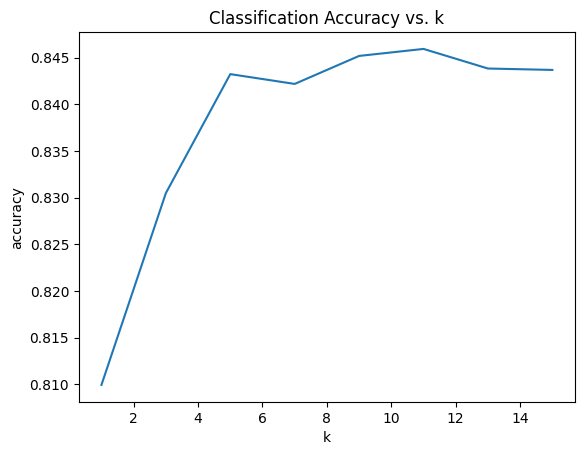

In [137]:
X, y, names = arffLoader().arf_to_x_y('magic_telescope_train.arff', data_type=str)
X = X.astype(float)

X_test, y_test, names = arffLoader().arf_to_x_y('magic_telescope_test.arff', data_type=str)
X_test = X_test.astype(float)

# Train/Predict with normalization using k=1,3,...,15
scores = []
k_values = [ k for k in range(1, 16, 2) ]
for k in k_values:
    clf = KNNClassifier(n_neighbors=k, weight_type='uniform', p=2, regression=False, normalize=True)
    clf.fit(X, y)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
print(scores)
# Graph classification accuracy over k
plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Classification Accuracy vs. k')
plt.show()

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [housing training set](https://byu.instructure.com/courses/14142/files?preview=4660994) and this [housing test set](https://byu.instructure.com/courses/14142/files?preview=4660995).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


[24.617254901960784, 16.598692810457518, 15.654439215686272, 19.093317326930766, 20.724105543451948, 23.418262842327017, 24.53476969486019, 24.384255337690632]


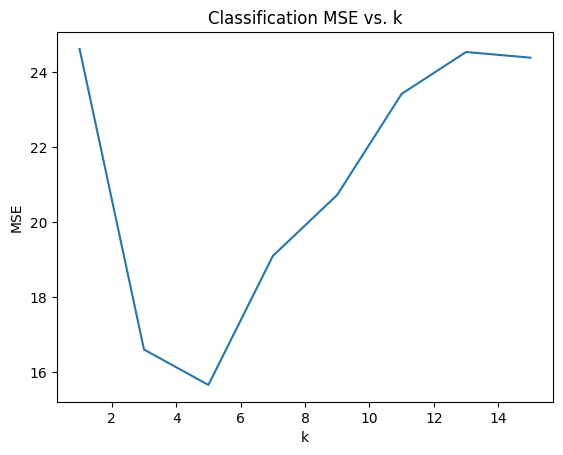

In [151]:
# Load housing price prediction data
X, y, names = arffLoader().arf_to_x_y('housing_train.arff', data_type=float)

X_test, y_test, names = arffLoader().arf_to_x_y('housing_test.arff', data_type=float)

# Train/Predict using k=1,3,...,15
scores = []
k_values = [ k for k in range(1, 16, 2) ]
for k in k_values:
    clf = KNNClassifier(n_neighbors=k, weight_type='uniform', p=2, regression=True, normalize=True)
    clf.fit(X, y)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
print(scores)
# Graph classification accuracy over k
plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Classification MSE vs. k')
plt.show()
# Graph MSE over k


## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


## 4.1 Magic Telescope Dataset

C:\Users\BYU Rental\AppData\Local\Temp\ipykernel_37332\2951644985.py:95: RuntimeWarning: divide by zero encountered in divide
  sum = np.sum((1 / np.square(neighbor_distances)) * (neighbor_y == target))
C:\Users\BYU Rental\AppData\Local\Temp\ipykernel_37332\2951644985.py:95: RuntimeWarning: invalid value encountered in multiply
  sum = np.sum((1 / np.square(neighbor_distances)) * (neighbor_y == target))


[0.8099309930993099, 0.8316831683168316, 0.8448844884488449, 0.84998499849985, 0.848034803480348, 0.8513351335133513, 0.8505850585058505, 0.8508850885088509]


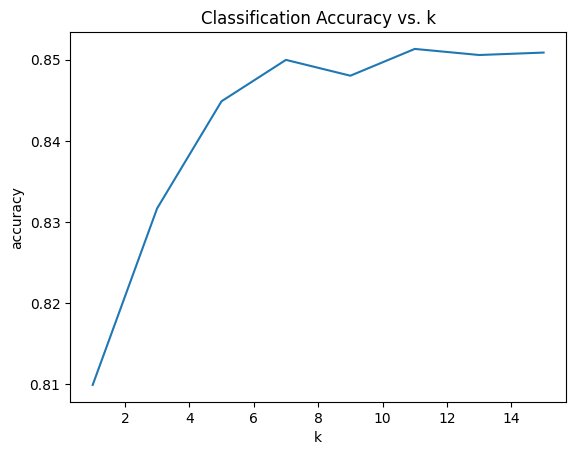

In [152]:
# Train/Predict magic telescope using distance-weighted voting
X, y, names = arffLoader().arf_to_x_y('magic_telescope_train.arff', data_type=str)
X = X.astype(float)

X_test, y_test, names = arffLoader().arf_to_x_y('magic_telescope_test.arff', data_type=str)
X_test = X_test.astype(float)

# Train/Predict with normalization using k=1,3,...,15
scores = []
k_values = [ k for k in range(1, 16, 2) ]
for k in k_values:
    clf = KNNClassifier(n_neighbors=k, weight_type='inverse_distance', p=2, regression=False, normalize=True)
    clf.fit(X, y)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
print(scores)
# Graph classification accuracy over k
plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Classification Accuracy vs. k')
plt.show()

## 4.2 Housing Dataset

[24.617254901960784, 16.294702431167742, 11.903946906365874, 10.770952575034784, 11.331357432559866, 11.44098857162627, 11.602299865930169, 11.929935864665262]


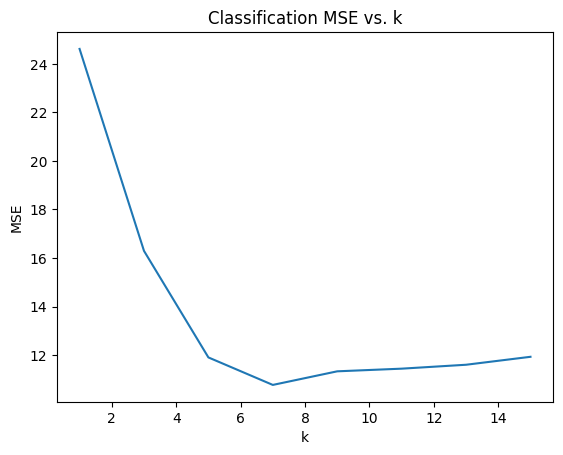

In [153]:
# Train/Predict housing using distance-weighted voting
X, y, names = arffLoader().arf_to_x_y('housing_train.arff', data_type=float)

X_test, y_test, names = arffLoader().arf_to_x_y('housing_test.arff', data_type=float)

# Train/Predict using k=1,3,...,15
scores = []
k_values = [ k for k in range(1, 16, 2) ]
for k in k_values:
    clf = KNNClassifier(n_neighbors=k, weight_type='inverse_distance', p=2, regression=True, normalize=True)
    clf.fit(X, y)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
print(scores)
# Graph classification accuracy over k
plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Classification MSE vs. k')
plt.show()
# Graph MSE over k


*Discuss your results*

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [credit approval dataset](https://byu.instructure.com/courses/14142/files?preview=4660998)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [155]:
# Load dataset and split into train/test sets
X, y, names = arffLoader().arf_to_x_y('credit_approval.arff', data_type=str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)


# Train/Predict credit-approval
clf = KNNClassifier(n_neighbors=12, weight_type='inverse-distance', p=2, regression=False, normalize=True)
clf.fit(X, y)
score = clf.score(X_test, y_test)
print(f'accuracy: {score}')



UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> None

*Explain and justify your distance metric*

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [ ]:
# Train/Predict magic telescope using scikit's KNN

# Train/Predict housing using scikit's KNN


*Report your comparison*

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - Examples of reduction techniques include: (a) leave-one-out reduction - Drop instance if it would still be classified correctly, (b) growth algorithm - Only add instance if it is not already classified correctly, (c) just keep central points, (d) just keep border points, etc. (see Wilson, D. R. and Martinez, T. R., Reduction Techniques for Exemplar-Based Learning Algorithms, Machine Learning Journal, vol. 38, no. 3, pp. 257-286, 2000).